# To do

* コレスキー分解 numpy.linalg.cholesky と scipy.linalg.lapack.dpotrf

* Chosolv


---

* テストコード https://www.youtube.com/watch?v=Hl8UNYrp0Vg


# 0. ライブラリのインポート & トイデータの準備

In [8]:
import numpy as np
import pandas as pd
import GPy
import pods

In [9]:
np.random.seed(seed=1)

In [10]:
data = pods.datasets.olympic_100m_men()
X, Y = data["X"], data["Y"]
X_pred = np.linspace(X[:,0].min() - 30,
                     X[:,0].max() + 30,
                     500).reshape(-1,1)

In [11]:
pd.concat([pd.DataFrame(X.T, index=["X"]), pd.DataFrame(Y.T, index=["Y"])], axis=0)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
X,1896.0,1900.0,1904.0,1906.0,1908.0,1912.0,1920.0,1924.0,1928.0,1932.0,...,1972.00,1976.00,1980.00,1984.00,1988.00,1992.00,1996.00,2000.00,2004.00,2008.00
Y,12.0,11.0,11.0,11.2,10.8,10.8,10.8,10.6,10.8,10.3,...,10.14,10.06,10.25,9.99,9.92,9.96,9.84,9.87,9.85,9.69


In [12]:
pd.DataFrame(X_pred.T, index=["X_pred"])

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
X_pred,1866.0,1866.344689,1866.689379,1867.034068,1867.378758,1867.723447,1868.068136,1868.412826,1868.757515,1869.102204,...,2034.897796,2035.242485,2035.587174,2035.931864,2036.276553,2036.621242,2036.965932,2037.310621,2037.655311,2038.0


# 1. RBFカーネル

$$k(x, x') = variance * \exp\left( -\frac{1}{2} \frac{|x - x'|^2}{lengthscale} \right)$$

In [13]:
class RBF:
    def __init__(self, variance=1., lengthscale=0.1):
        self.variance=variance
        self.lengthscale=lengthscale
        # self.r = self._euclidean_distance
        
    def K(self, X, X2=None):
        return self.variance * np.exp(-0.5 * (self._euc_dist(X, X2) / self.lengthscale)**2)
        # return self._euc_dist(X, X2)
        
    def _euc_dist(self, X, X2):
        if X2 is None:
            # print("X2 is None")
            # print(X2)
            Xsq = np.sum(np.square(X),1)
            r2 = -2.*(np.dot(X, X.T)) + (Xsq[:,None] + Xsq[None,:]) 
            r2 = np.clip(r2, 0, np.inf)
            np.fill_diagonal(r2, 0.)
            return np.sqrt(r2)
        else:
            # print(X)
            # print(X2)
            X1sq = np.sum(np.square(X),1)
            X2sq = np.sum(np.square(X2),1)
            r2 = -2.*np.dot(X, X2.T) + (X1sq[:,None] + X2sq[None,:])
            r2 = np.clip(r2, 0, np.inf)
            return np.sqrt(r2)

In [14]:
kern = RBF()
kern.variance, kern.lengthscale

(1.0, 0.1)

In [15]:
pd.DataFrame(kern.K(X, X_pred)).head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
kern.K(X, X_pred).max(), kern.K(X, X_pred).min()

(0.9927971862436876, 0.0)

ハイパーパラメータの値が重要

In [77]:
kern.lengthscale = 10.
kern.lengthscale

10.0

In [79]:
pd.DataFrame(kern.K(X, X_pred)).head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.011109,0.012312,0.013629,0.015069,0.016641,0.018356,0.020223,0.022253,0.024459,0.026851,...,1.278370e-42,7.915405e-43,4.895237e-43,3.023837e-43,1.865636e-43,1.149687e-43,7.076464e-44,4.350478e-44,2.671417e-44,1.638439e-44
1,0.003089,0.003471,0.003895,0.004367,0.004889,0.005468,0.006108,0.006814,0.007593,0.008452,...,3.053619e-40,1.916988e-40,1.202009e-40,7.528012e-41,4.709088e-41,2.942234e-41,1.836123e-41,1.144486e-41,7.125295e-42,4.430772e-42
2,0.000732,0.000834,0.000949,0.001078,0.001224,0.001388,0.001572,0.001778,0.002009,0.002267,...,6.215642e-38,3.956201e-38,2.515097e-38,1.597037e-38,1.012883e-38,6.416346e-39,4.059758e-39,2.565645e-39,1.619485e-39,1.021037e-39
3,0.000335,0.000385,0.000441,0.000505,0.000577,0.000659,0.000751,0.000855,0.000973,0.001106,...,8.351489e-37,5.352420e-37,3.426261e-37,2.190659e-37,1.398985e-37,8.923503e-38,5.685147e-38,3.617696e-38,2.299357e-38,1.459704e-38
4,0.000148,0.000171,0.000197,0.000227,0.000261,0.000300,0.000345,0.000395,0.000453,0.000518,...,1.078127e-35,6.957453e-36,4.484505e-36,2.887106e-36,1.856500e-36,1.192370e-36,7.649119e-37,4.901124e-37,3.136635e-37,2.005009e-37


In [80]:
kern.K(X, X_pred).max(), kern.K(X, X_pred).min()

(0.9999992771123355, 1.638439217006888e-44)

# 2. コレスキー分解

`custom_cholesky` 関数を作成

In [52]:
import numpy as np
from scipy import linalg
from scipy.linalg import lapack, blas
import traceback
import logging


def jitchol(A, maxtries=5):
    A = np.ascontiguousarray(A)
    L, info = lapack.dpotrf(A, lower=1)
    if info == 0:
        return L
    else:
        diagA = np.diag(A)
        if np.any(diagA <= 0.):
            raise linalg.LinAlgError("not pd: non-positive diagonal elements")
        jitter = diagA.mean() * 1e-6
        num_tries = 1
        while num_tries <= maxtries and np.isfinite(jitter):
            try:
                L = linalg.cholesky(A + np.eye(A.shape[0]) * jitter, lower=True)
                return L
            except:
                jitter *= 10
            finally:
                num_tries += 1
        raise linalg.LinAlgError("not positive definite, even with jitter.")

    try:
        raise
    except:
        logging.warning('\n'.join(['Added jitter of {:.10e}'.format(jitter),
                                   '  in ' + traceback.format_list(traceback.extract_stack(limit=3)[-2:-1])[0][2:]]))
    return L

In [135]:
class RBF:
    def __init__(self, variance=1., lengthscale=0.1):
        self.variance=variance
        self.lengthscale=lengthscale
        # self.r = self._euclidean_distance
        
    def K(self, X, X2=None):
        return self.variance * np.exp(-0.5 * (self._euc_dist(X, X2) / self.lengthscale)**2)
        # return self._euc_dist(X, X2)
        
    def _euc_dist(self, X, X2):
        if X2 is None:
            # print("X2 is None")
            # print(X2)
            Xsq = np.sum(np.square(X),1)
            r2 = -2.*(np.dot(X, X.T)) + (Xsq[:,None] + Xsq[None,:]) 
            r2 = np.clip(r2, 0, np.inf)
            np.fill_diagonal(r2, 0.)
            return np.sqrt(r2)
        else:
            # print(X)
            # print(X2)
            X1sq = np.sum(np.square(X),1)
            X2sq = np.sum(np.square(X2),1)
            r2 = -2.*np.dot(X, X2.T) + (X1sq[:,None] + X2sq[None,:])
            r2 = np.clip(r2, 0, np.inf)
            return np.sqrt(r2)


def generate_non_pd_mat():    
    # Create PD matrix
    A = np.random.randn(20, 100)
    A = A.dot(A.T)
    # Compute Eigdecomp
    vals, vectors = np.linalg.eig(A)
    # Set smallest eigenval to be negative with 5 rounds worth of jitter
    vals[vals.argmin()] = 0
    default_jitter = 1e-6 * np.mean(vals)
    vals[vals.argmin()] = -default_jitter * (10 ** 3.5)
    A_corrupt = (vectors * vals).dot(vectors.T)
    return A_corrupt


def custom_cholesky(A, max_tries=5):
    A = np.ascontiguousarray(A) # パフォーマンス向上 計算結果にも影響
    diag_A = np.diag(A)
    jitter = diag_A.mean() * 1e-6
    num_tries = 0
    
    try:
        L = cholesky(A, lower=True)
        return L
    except LinAlgError:
        num_tries += 1
        
    while num_tries <= max_tries and np.isfinite(jitter):
        try:
            L = cholesky(A + np.eye(A.shape[0]) * jitter, lower=True)
            return L
        except LinAlgError:
            jitter *= 10
            num_tries += 1
    
    raise LinAlgError("Matrix is not positive definite, even with jitter.")

In [136]:
A = generate_non_pd_mat()
np.linalg.cholesky(A)

LinAlgError: Matrix is not positive definite

In [137]:
lapack.dpotrf(A)

(array([[ 9.65081412,  0.33582105, -1.68565454, -1.14139877, -0.37228016,
         -0.17195544, -0.7136588 ,  1.37156911, -0.77773783,  0.02386796,
          0.57549029, -1.85623697, -1.63678659, -1.97397285, -0.29475409,
          0.62568007,  0.69315421, -1.35694038, -0.07766662, -1.14655859],
        [ 0.        ,  8.77726227, -1.00289126, -1.73135024, -0.30927861,
         -0.51627505,  0.49946822, -0.90580208, -0.73003844, -1.16834791,
          1.26743552,  0.76388433, -0.34926526, -0.35713272, -0.30200429,
          0.26370762,  1.18092124,  1.08678571, -1.55762634,  0.04723639],
        [ 0.        ,  0.        ,  8.26585999,  2.42290979,  1.72457824,
         -0.91897196,  1.7103156 ,  2.75443181, -1.34556061,  2.46243475,
         -1.48284766, -2.09251147, -0.89632598, -0.03501279,  0.65255423,
          2.77734342,  0.82520118, -1.91278654, -0.18600112, -0.98087357],
        [ 0.        ,  0.        ,  0.        ,  9.07474373,  0.01938929,
         -1.49210495,  1.05049838, 

In [138]:
jitchol(A)

array([[ 9.70003086,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.33411714,  8.83141325,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-1.67710174, -0.9973907 ,  8.32565856,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-1.13560746, -1.72117356,  2.41020951,  9.13307523,  0.        ,
         0.        ,  0.        ,  0.        ,  

In [139]:
pd.DataFrame(jitchol(A))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,9.700031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.334117,8.831413,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,-1.677102,-0.997391,8.325659,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,-1.135607,-1.721174,2.410210,9.133075,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,-0.370391,-0.307526,1.713369,0.025768,10.915215,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,-0.171083,-0.513176,-0.911307,-1.484499,0.028086,10.288780,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,-0.710038,0.496131,1.698764,1.048933,-0.812588,-1.080877,10.198181,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,1.364610,-0.899720,2.733164,-0.116862,0.078521,-1.269719,-0.829489,9.260613,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,-0.773792,-0.725861,-1.333320,0.630858,0.036530,0.336257,0.405599,1.452750,8.641236,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.023747,-1.161175,2.446331,-0.857159,0.318678,-1.437400,-1.052958,-1.175322,0.111691,9.409254,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [140]:
import numpy as np
from scipy.linalg import cholesky, LinAlgError


def custom_cholesky(A, max_tries=5):
    A = np.ascontiguousarray(A) # パフォーマンス向上 計算結果にも影響
    diag_A = np.diag(A)
    jitter = diag_A.mean() * 1e-6
    num_tries = 0
    
    try:
        L = cholesky(A, lower=True)
        return L
    except LinAlgError:
        num_tries += 1
        
    while num_tries <= max_tries and np.isfinite(jitter):
        try:
            L = cholesky(A + np.eye(A.shape[0]) * jitter, lower=True)
            return L
        except LinAlgError:
            jitter *= 10
            num_tries += 1
    
    raise LinAlgError("Matrix is not positive definite, even with jitter.")

In [141]:
for i in range(50):
    A = generate_non_pd_mat()
    B = jitchol(A)
    C = custom_cholesky(A)
    print(np.unique(B == C))

[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]


In [142]:
def np_custom_cholesky(A, max_tries=5):
    A = np.ascontiguousarray(A) # パフォーマンス向上 計算結果にも影響
    diag_A = np.diag(A)
    jitter = diag_A.mean() * 1e-6
    num_tries = 0
    
    try:
        L = np.linalg.cholesky(A)
        return L
    except LinAlgError:
        num_tries += 1
        
    while num_tries <= max_tries and np.isfinite(jitter):
        try:
            L = np.linalg.cholesky(A + np.eye(A.shape[0]) * jitter)
            return L
        except LinAlgError:
            jitter *= 10
            num_tries += 1
    
    raise LinAlgError("Matrix is not positive definite, even with jitter.")

In [205]:
for i in range(50):
    A = generate_non_pd_mat()
    # B = jitchol(A)
    C = custom_cholesky(A)
    D = np_custom_cholesky(A)
    print(np.unique(C == D))

[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]


# 3. 連立方程式のコレスキー分解を利用した解法

$$\begin{align*}
p( y^* | X^*, \mathcal D) = \mathcal N  ( y^* | K_{N*}^T ( \sigma^2 I &+ K_{NN})^{-1} y, K_{**} - K_{N*}^T (\sigma^2 I + K_{NN})^{-1}  K_{N*})
\end{align*}$$

In [215]:
from scipy.linalg import solve_triangular

In [222]:
noise = 1.
noise

1.0

In [219]:
kern = RBF()
kern.lengthscale = 10.
kern.variance, kern.lengthscale

(1.0, 10.0)

In [226]:
K = kern.K(X, X)
print(K.shape)
pd.DataFrame(K).head()

(27, 27)


,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,1.000000,0.923116,0.726149,0.606531,0.486752,0.278037,0.056135,0.019841,0.005976,0.001534,...,2.867975e-13,1.266417e-14,4.765305e-16,1.527980e-17,4.175010e-19,9.720985e-21,1.928750e-22,3.261027e-24,4.698355e-26,5.768330e-28
1,0.923116,1.000000,0.923116,0.835270,0.726149,0.486752,0.135335,0.056135,0.019841,0.005976,...,5.534610e-12,2.867975e-13,1.266417e-14,4.765305e-16,1.527980e-17,4.175010e-19,9.720985e-21,1.928750e-22,3.261027e-24,4.698355e-26
2,0.726149,0.923116,1.000000,0.980199,0.923116,0.726149,0.278037,0.135335,0.056135,0.019841,...,9.101471e-11,5.534610e-12,2.867975e-13,1.266417e-14,4.765305e-16,1.527980e-17,4.175010e-19,9.720985e-21,1.928750e-22,3.261027e-24
3,0.606531,0.835270,0.980199,1.000000,0.980199,0.835270,0.375311,0.197899,0.088922,0.034047,...,3.475891e-10,2.289735e-11,1.285337e-12,6.148396e-14,2.506222e-15,8.705427e-17,2.576757e-18,6.499348e-20,1.396944e-21,2.558592e-23
4,0.486752,0.726149,0.923116,0.980199,1.000000,0.923116,0.486752,0.278037,0.135335,0.056135,...,1.275408e-09,9.101471e-11,5.534610e-12,2.867975e-13,1.266417e-14,4.765305e-16,1.527980e-17,4.175010e-19,9.720985e-21,1.928750e-22


In [232]:
L = custom_cholesky(K + noise*np.eye(K.shape[0]))
LT = L.T

print(L.shape)
display(pd.DataFrame(L).head())
print(LT.shape)
display(pd.DataFrame(LT).head())

(27, 27)


,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,1.414214,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.652742,1.254563,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.513465,0.468654,1.231551,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.428882,0.442641,0.448652,1.191151,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.344186,0.399729,0.453944,0.379452,1.171198,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(27, 27)


,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,1.414214,0.652742,0.513465,0.428882,0.344186,0.196602,0.039693,0.014030,0.004226,0.001085,...,2.027965e-13,8.954917e-15,3.369579e-16,1.080445e-17,2.952178e-19,6.873774e-21,1.363832e-22,2.305894e-24,3.322239e-26,4.078825e-28
1,0.000000,1.254563,0.468654,0.442641,0.399729,0.285695,0.087222,0.037445,0.013617,0.004199,...,4.306070e-12,2.239443e-13,9.919167e-15,3.742164e-16,1.202578e-17,3.292096e-19,7.677544e-21,1.525390e-22,2.582048e-24,3.723791e-26
2,0.000000,0.000000,1.231551,0.448652,0.453944,0.398935,0.176021,0.089792,0.038637,0.014061,...,7.217935e-11,4.405064e-12,2.289600e-13,1.013620e-14,3.822360e-16,1.227882e-17,3.360259e-19,7.834280e-21,1.556151e-22,2.633563e-24
3,0.000000,0.000000,0.000000,1.191151,0.379452,0.374015,0.202079,0.113354,0.053518,0.021337,...,2.629496e-10,1.747725e-11,9.890255e-13,4.765648e-14,1.955488e-15,6.833448e-17,2.033782e-18,5.155526e-20,1.113184e-21,2.047407e-23
4,0.000000,0.000000,0.000000,0.000000,1.171198,0.357099,0.240473,0.148965,0.077349,0.033815,...,9.742798e-10,7.026198e-11,4.312940e-12,2.253757e-13,1.002711e-14,3.798615e-16,1.225448e-17,3.366811e-19,7.878174e-21,1.570149e-22


In [246]:
alpha = solve_triangular(LT, solve_triangular(L, Y, lower=True))

In [247]:
K_starN = kern.K(X, X_pred).T
K_starN.shape

(500, 27)

In [248]:
mu = K_starN @ alpha

In [251]:
pd.DataFrame(mu.T, index=['mu'])

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
mu,0.049292,0.054763,0.060772,0.067363,0.074585,0.082486,0.091122,0.100547,0.110821,0.122007,...,0.097011,0.088061,0.079846,0.072316,0.065422,0.059118,0.053361,0.04811,0.043326,0.038974


## ↑ GPyの計算結果と一致した

In [220]:
mu = kern.K(X, X_pred) @ 

array([[1.11089965e-02, 1.23119217e-02, 1.36289021e-02, ...,
        4.35047795e-44, 2.67141677e-44, 1.63843922e-44],
       [3.08871541e-03, 3.47069761e-03, 3.89528887e-03, ...,
        1.14448560e-41, 7.12529547e-42, 4.43077231e-42],
       [7.31802419e-04, 8.33720712e-04, 9.48705355e-04, ...,
        2.56564510e-39, 1.61948523e-39, 1.02103685e-39],
       ...,
       [1.02103685e-39, 1.61948523e-39, 2.56564510e-39, ...,
        9.48705355e-04, 8.33720712e-04, 7.31802419e-04],
       [4.43077231e-42, 7.12529547e-42, 1.14448560e-41, ...,
        3.89528887e-03, 3.47069761e-03, 3.08871541e-03],
       [1.63843922e-44, 2.67141677e-44, 4.35047795e-44, ...,
        1.36289021e-02, 1.23119217e-02, 1.11089965e-02]])

In [ ]:
from scipy.linalg import solve_triangular

def _raw_predict(self, kern, Xnew, pred_var, full_cov=False):
    woodbury_vector = self.woodbury_vector
    woodbury_inv = self.woodbury_inv

    if not isinstance(Xnew, VariationalPosterior):
        Kx = kern.K(pred_var, Xnew)
        mu = np.dot(Kx.T, woodbury_vector)
        if len(mu.shape) == 1:
            mu = mu.reshape(-1, 1)
        if full_cov:
            Kxx = kern.K(Xnew)
            if woodbury_inv.ndim == 2:
                var = Kxx - np.dot(Kx.T, np.dot(woodbury_inv, Kx))
            elif woodbury_inv.ndim == 3:  # Missing data
                var = np.empty((Kxx.shape[0], Kxx.shape[1], woodbury_inv.shape[2]))
                from ...util.linalg import mdot
                for i in range(var.shape[2]):
                    var[:, :, i] = (Kxx - mdot(Kx.T, woodbury_inv[:, :, i], Kx))
            var = var
        else:
            Kxx = kern.Kdiag(Xnew)
            if woodbury_inv.ndim == 2:
                var = (Kxx - np.sum(np.dot(woodbury_inv.T, Kx) * Kx, 0))[:, None]
            elif woodbury_inv.ndim == 3:  # Missing data
                var = np.empty((Kxx.shape[0], woodbury_inv.shape[2]))
                for i in range(var.shape[1]):
                    var[:, i] = (Kxx - (np.sum(np.dot(woodbury_inv[:, :, i].T, Kx) * Kx, 0)))
            var = var
            var = np.clip(var, 1e-15, np.inf)
    return mu, var

In [ ]:
_K = 
_K_chol = 
_woodbury_chol = 
_woodbury_vector = 


# 4. サンプリング

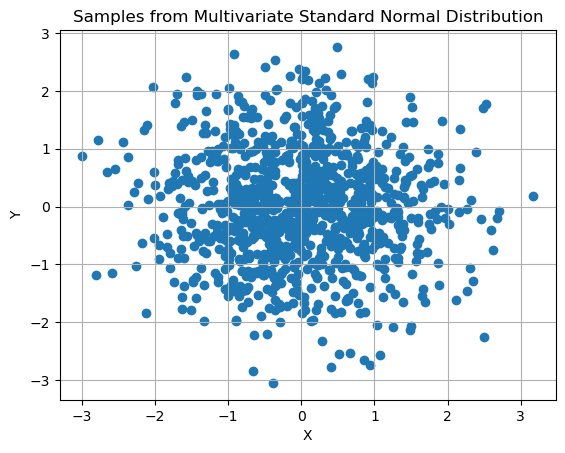

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 乱数のシード値を設定（再現性のため）
np.random.seed(0)

# サンプル数と次元数を指定
n_samples = 1000
n_dimensions = 2

# 多変量標準正規分布からサンプリング
samples = np.random.multivariate_normal(mean=[0, 0], cov=[[1, 0], [0, 1]], size=n_samples)

# サンプルの可視化
plt.scatter(samples[:, 0], samples[:, 1])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Samples from Multivariate Standard Normal Distribution')
plt.grid(True)
plt.show()

In [3]:
samples.shape

(1000, 2)

In [7]:
custom_cholesky(np.random.rand(10,10))

NameError: name 'custom_cholesky' is not defined

# 実行

In [42]:
from scipy.linalg import cholesky, solve_triangular, LinAlgError
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pods

In [43]:
data = pods.datasets.olympic_100m_men()
X, Y = data["X"], data["Y"]
X_pred = np.linspace(X[:,0].min() - 30,
                     X[:,0].max() + 30,
                     500).reshape(-1,1)

In [44]:
class RBF:
    def __init__(self, variance=1., lengthscale=0.1):
        self.variance=variance
        self.lengthscale=lengthscale
        # self.r = self._euclidean_distance
        
    def K(self, X, X2=None):
        return self.variance * np.exp(-0.5 * (self._euc_dist(X, X2) / self.lengthscale)**2)
        # return self._euc_dist(X, X2)
        
    def _euc_dist(self, X, X2):
        if X2 is None:
            # print("X2 is None")
            # print(X2)
            Xsq = np.sum(np.square(X),1)
            r2 = -2.*(np.dot(X, X.T)) + (Xsq[:,None] + Xsq[None,:]) 
            r2 = np.clip(r2, 0, np.inf)
            np.fill_diagonal(r2, 0.)
            return np.sqrt(r2)
        else:
            # print(X)
            # print(X2)
            X1sq = np.sum(np.square(X),1)
            X2sq = np.sum(np.square(X2),1)
            r2 = -2.*np.dot(X, X2.T) + (X1sq[:,None] + X2sq[None,:])
            r2 = np.clip(r2, 0, np.inf)
            return np.sqrt(r2)


def generate_non_pd_mat():    
    # Create PD matrix
    A = np.random.randn(20, 100)
    A = A.dot(A.T)
    # Compute Eigdecomp
    vals, vectors = np.linalg.eig(A)
    # Set smallest eigenval to be negative with 5 rounds worth of jitter
    vals[vals.argmin()] = 0
    default_jitter = 1e-6 * np.mean(vals)
    vals[vals.argmin()] = -default_jitter * (10 ** 3.5)
    A_corrupt = (vectors * vals).dot(vectors.T)
    return A_corrupt


def custom_cholesky(A, max_tries=5):
    A = np.ascontiguousarray(A) # パフォーマンス向上 計算結果にも影響
    diag_A = np.diag(A)
    jitter = diag_A.mean() * 1e-6
    num_tries = 0
    
    try:
        L = cholesky(A, lower=True)
        return L
    except LinAlgError:
        num_tries += 1
        
    while num_tries <= max_tries and np.isfinite(jitter):
        try:
            L = cholesky(A + np.eye(A.shape[0]) * jitter, lower=True)
            return L
        except LinAlgError:
            jitter *= 10
            num_tries += 1
    
    raise LinAlgError("Matrix is not positive definite, even with jitter.")

In [ ]:
class GPR:
    def __init__(self, X, y, kernel=None, mean_function=None):
        self.X = X
        self.y = y
        
        if kernel is None:
            kernel = RBF()
            self.kernel = kernel

        if mean_function is None:
            self.mean_function = np.zeros(self.X.shape[0]).reshape(-1,1)

        # self.K = self.kernel.K(self.X)
        self.mean = np.zeros(self.X.shape[0])

            
    def plot_sampled_prior(self, size=None):
        plt.figure()

        extension = np.abs(self.X.min() - self.X.max()) * 0.1
        X = np.linspace(self.X.min() - extension,
                        self.X.max() + extension,
                        200).reshape(-1,1)
        K = self.kernel.K(X)
        L = cholesky(K)
        n = X.shape[0]
        samples = np.random.multivariate_normal(np.zeros(n), np.eye(n), size=size) # generate x from N(0, I)

        if size == None:
            sample = L @ samples
            plt.plot(X.ravel(), sample, lw=1, ls='--')
        else:
            samples = [L @ sample for sample in samples] # y = L @ x
            for sample in samples:
                plt.plot(X.ravel(), sample, lw=1, ls='--')

        plt.show()



class Posterior:
    def __init__(self, woodbury_chol=None, woodbury_vector=None, K=None, mean=None, cov=None, K_chol=None,
                 woodbury_inv=None, prior_mean=0):
        """
        woodbury_chol : a lower triangular matrix L that satisfies posterior_covariance = K - K L^{-T} L^{-1} K
        woodbury_vector : a matrix (or vector, as Nx1 matrix) M which satisfies posterior_mean = K M
        K : the proir covariance (required for lazy computation of various quantities)
        mean : the posterior mean
        cov : the posterior covariance

        Not all of the above need to be supplied! You *must* supply:

          K (for lazy computation)
          or
          K_chol (for lazy computation)

       You may supply either:

          woodbury_chol
          woodbury_vector

        Or:

          mean
          cov

        Of course, you can supply more than that, but this class will lazily
        compute all other quantites on demand.

        """
        # obligatory
        self._K = K

        if ((woodbury_chol is not None) and (woodbury_vector is not None)) \
                or ((woodbury_inv is not None) and (woodbury_vector is not None)) \
                or ((woodbury_inv is not None) and (mean is not None)) \
                or ((mean is not None) and (cov is not None)):
            pass  # we have sufficient to compute the posterior
        else:
            raise ValueError("insufficient information to compute the posterior")

        self._K_chol = K_chol
        self._K = K
        # option 1:
        self._woodbury_chol = woodbury_chol
        self._woodbury_vector = woodbury_vector

        # option 2.
        self._woodbury_inv = woodbury_inv
        # and woodbury vector

        # option 2:
        self._mean = mean
        self._covariance = cov
        self._prior_mean = prior_mean

        # compute this lazily
        self._precision = None

    @property
    def mean(self):
        """
        Posterior mean
        $$
        K_{xx}v
        v := \texttt{Woodbury vector}
        $$
        """
        if self._mean is None:
            self._mean = np.dot(self._K, self.woodbury_vector)
        return self._mean

    @property
    def covariance(self):
        """
        Posterior covariance
        $$
        K_{xx} - K_{xx}W_{xx}^{-1}K_{xx}
        W_{xx} := \texttt{Woodbury inv}
        $$
        """
        if self._covariance is None:
            # LiK, _ = dtrtrs(self.woodbury_chol, self._K, lower=1)
            self._covariance = (
            np.atleast_3d(self._K) - np.tensordot(np.dot(np.atleast_3d(self.woodbury_inv).T, self._K), self._K,
                                                  [1, 0]).T).squeeze()
            # self._covariance = self._K - self._K.dot(self.woodbury_inv).dot(self._K)
        return self._covariance

    @property
    def woodbury_chol(self):
        """
        return $L_{W}$ where L is the lower triangular Cholesky decomposition of the Woodbury matrix
        $$
        L_{W}L_{W}^{\top} = W^{-1}
        W^{-1} := \texttt{Woodbury inv}
        $$
        """
        if self._woodbury_chol is None:
            # compute woodbury chol from
            if self._woodbury_inv is not None:
                winv = np.atleast_3d(self._woodbury_inv)
                self._woodbury_chol = np.zeros(winv.shape)
                for p in range(winv.shape[-1]):
                    self._woodbury_chol[:, :, p] = pdinv(winv[:, :, p])[2]
                    # Li = jitchol(self._woodbury_inv)
                    # self._woodbury_chol, _ = dtrtri(Li)
                    # W, _, _, _, = pdinv(self._woodbury_inv)
                    # symmetrify(W)
                    # self._woodbury_chol = jitchol(W)
            # try computing woodbury chol from cov
            elif self._covariance is not None:
                raise NotImplementedError("TODO: check code here")
                B = self._K - self._covariance
                tmp, _ = dpotrs(self.K_chol, B)
                self._woodbury_inv, _ = dpotrs(self.K_chol, tmp.T)
                _, _, self._woodbury_chol, _ = pdinv(self._woodbury_inv)
            else:
                raise ValueError("insufficient information to compute posterior")
        return self._woodbury_chol

    @property
    def woodbury_inv(self):
        """
        The inverse of the woodbury matrix, in the gaussian likelihood case it is defined as
        $$
        (K_{xx} + \Sigma_{xx})^{-1}
        \Sigma_{xx} := \texttt{Likelihood.variance / Approximate likelihood covariance}
        $$
        """
        if self._woodbury_inv is None:
            if self._woodbury_chol is not None:
                self._woodbury_inv, _ = dpotri(self._woodbury_chol, lower=1)
                # self._woodbury_inv, _ = dpotrs(self.woodbury_chol, np.eye(self.woodbury_chol.shape[0]), lower=1)
                symmetrify(self._woodbury_inv)
            elif self._covariance is not None:
                B = np.atleast_3d(self._K) - np.atleast_3d(self._covariance)
                self._woodbury_inv = np.empty_like(B)
                for i in range(B.shape[-1]):
                    tmp, _ = dpotrs(self.K_chol, B[:, :, i])
                    self._woodbury_inv[:, :, i], _ = dpotrs(self.K_chol, tmp.T)
        return self._woodbury_inv

    @property
    def woodbury_vector(self):
        """
        Woodbury vector in the gaussian likelihood case only is defined as
        $$
        (K_{xx} + \Sigma)^{-1}Y
        \Sigma := \texttt{Likelihood.variance / Approximate likelihood covariance}
        $$
        """
        if self._woodbury_vector is None:
            self._woodbury_vector, _ = dpotrs(self.K_chol, self.mean - self._prior_mean)
        return self._woodbury_vector

    @property
    def K_chol(self):
        """
        Cholesky of the prior covariance K
        """
        if self._K_chol is None:
            self._K_chol = jitchol(self._K)
        return self._K_chol

    def _raw_predict(self, kern, Xnew, pred_var, full_cov=False):
        woodbury_vector = self.woodbury_vector
        woodbury_inv = self.woodbury_inv

        if not isinstance(Xnew, VariationalPosterior):
            Kx = kern.K(pred_var, Xnew)
            mu = np.dot(Kx.T, woodbury_vector)
            if len(mu.shape) == 1:
                mu = mu.reshape(-1, 1)
            if full_cov:
                Kxx = kern.K(Xnew)
                if woodbury_inv.ndim == 2:
                    var = Kxx - np.dot(Kx.T, np.dot(woodbury_inv, Kx))
                elif woodbury_inv.ndim == 3:  # Missing data
                    var = np.empty((Kxx.shape[0], Kxx.shape[1], woodbury_inv.shape[2]))
                    from ...util.linalg import mdot
                    for i in range(var.shape[2]):
                        var[:, :, i] = (Kxx - mdot(Kx.T, woodbury_inv[:, :, i], Kx))
                var = var
            else:
                Kxx = kern.Kdiag(Xnew)
                if woodbury_inv.ndim == 2:
                    var = (Kxx - np.sum(np.dot(woodbury_inv.T, Kx) * Kx, 0))[:, None]
                elif woodbury_inv.ndim == 3:  # Missing data
                    var = np.empty((Kxx.shape[0], woodbury_inv.shape[2]))
                    for i in range(var.shape[1]):
                        var[:, i] = (Kxx - (np.sum(np.dot(woodbury_inv[:, :, i].T, Kx) * Kx, 0)))
                var = var
                var = np.clip(var, 1e-15, np.inf)
        else:
            psi0_star = kern.psi0(pred_var, Xnew)
            psi1_star = kern.psi1(pred_var, Xnew)
            psi2_star = kern.psi2n(pred_var, Xnew)
            la = woodbury_vector
            mu = np.dot(psi1_star, la)  # TODO: dimensions?
            N, M, D = psi0_star.shape[0], psi1_star.shape[1], la.shape[1]

            if full_cov:
                raise NotImplementedError(
                    "Full covariance for Sparse GP predicted with uncertain inputs not implemented yet.")
                var = np.zeros((Xnew.shape[0], la.shape[1], la.shape[1]))
                di = np.diag_indices(la.shape[1])
            else:
                tmp = psi2_star - psi1_star[:, :, None] * psi1_star[:, None, :]
                var = (tmp.reshape(-1, M).dot(la).reshape(N, M, D) * la[None, :, :]).sum(1) + psi0_star[:, None]
                if woodbury_inv.ndim == 2:
                    var += -psi2_star.reshape(N, -1).dot(woodbury_inv.flat)[:, None]
                else:
                    var += -psi2_star.reshape(N, -1).dot(woodbury_inv.reshape(-1, D))
                var = np.clip(var, 1e-15, np.inf)
        return mu, var

# lapack テスト

In [ ]:
# dpotri == dtrtri(jitchol).T @ dtrtri(jichol) かどうかを調べる

In [ ]:
from scipy.linalg.lapack import dtrtri, dpotri

kern = RBF()
A = kern.K(X)

In [ ]:
kern = RBF()
A = kern.K(X)
pd.DataFrame(A).head()

In [ ]:
B, _ = dpotri(A)
pd.DataFrame(B)

In [ ]:
tmp, _ = dtrtri(custom_cholesky(A))
C = tmp.T @ tmp
pd.DataFrame(C)

In [ ]:
pd.DataFrame(B == C)

In [171]:
from scipy.linalg.lapack import dtrtri, dpotri, dpotrs

kern = RBF(variance=1., lengthscale=10.)
A = kern.K(X)
A = custom_cholesky(A)

In [172]:
B, _ = dpotri(A, lower=1)
C, _ = dpotrs(A, np.eye(A.shape[0]), lower=1)

In [173]:
display(pd.DataFrame(B).head())
display(pd.DataFrame(C).head())
display(pd.DataFrame(B == C).head())

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,6529.636653,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-49789.669349,3.897652e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,337427.444002,-2.700798e+06,1.909732e+07,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-663595.626671,5.363697e+06,-3.828212e+07,7.708077e+07,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,471953.801633,-3.849155e+06,2.771503e+07,-5.604223e+07,4.091499e+07,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,6529.636653,-4.978967e+04,3.374274e+05,-6.635956e+05,4.719538e+05,-1.280618e+05,8.147893e+04,-1.189027e+05,1.129237e+05,-7.621587e+04,...,-3.090321e+05,2.724627e+05,-2.186140e+05,1.586671e+05,-1.028463e+05,5.826470e+04,-2.785273e+04,1.058546e+04,-2855.713609,411.815549
1,-49789.669349,3.897652e+05,-2.700798e+06,5.363697e+06,-3.849155e+06,1.061128e+06,-6.919209e+05,1.019243e+06,-9.755998e+05,6.627665e+05,...,2.759507e+06,-2.434967e+06,1.955077e+06,-1.419790e+06,9.207405e+05,-5.218337e+05,2.495425e+05,-9.486658e+04,25599.148218,-3692.362943
2,337427.444002,-2.700798e+06,1.909732e+07,-3.828212e+07,2.771503e+07,-7.763568e+06,5.195464e+06,-7.732329e+06,7.466076e+06,-5.109446e+06,...,-2.193786e+07,1.937668e+07,-1.557060e+07,1.131524e+07,-7.342226e+06,4.163265e+06,-1.991704e+06,7.574330e+05,-204448.539487,29496.525374
3,-663595.626671,5.363697e+06,-3.828212e+07,7.708077e+07,-5.604223e+07,1.582375e+07,-1.073221e+07,1.606011e+07,-1.558019e+07,1.070520e+07,...,4.675887e+07,-4.132279e+07,3.322134e+07,-2.415157e+07,1.567660e+07,-8.891573e+06,4.254720e+06,-1.618364e+06,436906.750715,-63043.042853
4,471953.801633,-3.849155e+06,2.771503e+07,-5.604223e+07,4.091499e+07,-1.164346e+07,8.005067e+06,-1.204718e+07,1.174492e+07,-8.104227e+06,...,-3.605737e+07,3.188466e+07,-2.564657e+07,1.865273e+07,-1.211170e+07,6.871681e+06,-3.289020e+06,1.251312e+06,-337876.114816,48761.068994


,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [174]:
def symmetrify_matrix(A, upper=False):
    triu = np.triu_indices_from(A,k=1)
    if upper:
        A.T[triu] = A[triu]
    else:
        A[triu] = A.T[triu]
    return A

In [175]:
B = symmetrify_matrix(B)
pd.DataFrame(B).head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,6529.636653,-4.978967e+04,3.374274e+05,-6.635956e+05,4.719538e+05,-1.280618e+05,8.147893e+04,-1.189027e+05,1.129237e+05,-7.621587e+04,...,-3.090321e+05,2.724627e+05,-2.186140e+05,1.586671e+05,-1.028463e+05,5.826470e+04,-2.785273e+04,1.058546e+04,-2855.713609,411.815549
1,-49789.669349,3.897652e+05,-2.700798e+06,5.363697e+06,-3.849155e+06,1.061128e+06,-6.919209e+05,1.019243e+06,-9.755998e+05,6.627665e+05,...,2.759507e+06,-2.434967e+06,1.955077e+06,-1.419790e+06,9.207405e+05,-5.218337e+05,2.495425e+05,-9.486658e+04,25599.148218,-3692.362943
2,337427.444002,-2.700798e+06,1.909732e+07,-3.828212e+07,2.771503e+07,-7.763568e+06,5.195464e+06,-7.732329e+06,7.466076e+06,-5.109446e+06,...,-2.193786e+07,1.937668e+07,-1.557060e+07,1.131524e+07,-7.342226e+06,4.163265e+06,-1.991704e+06,7.574330e+05,-204448.539487,29496.525374
3,-663595.626671,5.363697e+06,-3.828212e+07,7.708077e+07,-5.604223e+07,1.582375e+07,-1.073221e+07,1.606011e+07,-1.558019e+07,1.070520e+07,...,4.675887e+07,-4.132279e+07,3.322134e+07,-2.415157e+07,1.567660e+07,-8.891573e+06,4.254720e+06,-1.618364e+06,436906.750716,-63043.042853
4,471953.801633,-3.849155e+06,2.771503e+07,-5.604223e+07,4.091499e+07,-1.164346e+07,8.005067e+06,-1.204718e+07,1.174492e+07,-8.104227e+06,...,-3.605737e+07,3.188466e+07,-2.564657e+07,1.865273e+07,-1.211170e+07,6.871681e+06,-3.289020e+06,1.251312e+06,-337876.114817,48761.068994


In [170]:
pd.DataFrame(symmetrify_matrix(B))

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,1.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
1,0.0,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
2,0.0,0.0,1.000000e+00,-1.383897e-87,1.915170e-174,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
3,0.0,0.0,-1.383897e-87,1.000000e+00,-1.383897e-87,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
4,0.0,0.0,1.915170e-174,-1.383897e-87,1.000000e+00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
5,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
6,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
7,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
8,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
9,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0


In [179]:
D = solve_triangular(A.T, solve_triangular(A, np.eye(A.shape[0]), lower=True))
pd.DataFrame(D).head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,6529.636653,-4.978967e+04,3.374274e+05,-6.635956e+05,4.719538e+05,-1.280618e+05,8.147893e+04,-1.189027e+05,1.129237e+05,-7.621587e+04,...,-3.090321e+05,2.724627e+05,-2.186140e+05,1.586671e+05,-1.028463e+05,5.826470e+04,-2.785273e+04,1.058546e+04,-2855.713609,411.815549
1,-49789.669349,3.897652e+05,-2.700798e+06,5.363697e+06,-3.849155e+06,1.061128e+06,-6.919209e+05,1.019243e+06,-9.755998e+05,6.627665e+05,...,2.759507e+06,-2.434967e+06,1.955077e+06,-1.419790e+06,9.207405e+05,-5.218337e+05,2.495425e+05,-9.486658e+04,25599.148218,-3692.362943
2,337427.444002,-2.700798e+06,1.909732e+07,-3.828212e+07,2.771503e+07,-7.763568e+06,5.195464e+06,-7.732329e+06,7.466076e+06,-5.109446e+06,...,-2.193786e+07,1.937668e+07,-1.557060e+07,1.131524e+07,-7.342226e+06,4.163265e+06,-1.991704e+06,7.574330e+05,-204448.539487,29496.525374
3,-663595.626671,5.363697e+06,-3.828212e+07,7.708077e+07,-5.604223e+07,1.582375e+07,-1.073221e+07,1.606011e+07,-1.558019e+07,1.070520e+07,...,4.675887e+07,-4.132279e+07,3.322134e+07,-2.415157e+07,1.567660e+07,-8.891573e+06,4.254720e+06,-1.618364e+06,436906.750715,-63043.042853
4,471953.801633,-3.849155e+06,2.771503e+07,-5.604223e+07,4.091499e+07,-1.164346e+07,8.005067e+06,-1.204718e+07,1.174492e+07,-8.104227e+06,...,-3.605737e+07,3.188466e+07,-2.564657e+07,1.865273e+07,-1.211170e+07,6.871681e+06,-3.289020e+06,1.251312e+06,-337876.114816,48761.068994


In [181]:
display(pd.DataFrame(B == D))
display(pd.DataFrame(C == D))

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
5,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
6,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
7,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
8,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
9,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [186]:
np.unique(C == D)

array([ True])